In [3]:
import argparse
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

In [4]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [5]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [6]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [7]:
# get all well fovs for this patient
all_well_fovs = input_dir.glob("*")
all_well_fovs = sorted([wf.name for wf in all_well_fovs if wf.is_dir()])
images_to_process = {"patient": [], "well_fov": [], "image": []}
for well_fov in tqdm.tqdm(all_well_fovs):
    image_path = pathlib.Path(f"{input_dir}/{well_fov}/").resolve(strict=True)
    image_to_load = [x for x in image_path.glob("*.tif") if "555" in x.name]
    image = read_zstack_image(image_to_load[0])
    # load the middle slice to check if there is anything there
    mid_slice = image.shape[0] // 2
    image_mid = image[mid_slice, :, :]
    images_to_process["patient"].append(patient)
    images_to_process["well_fov"].append(well_fov)
    images_to_process["image"].append(image_mid)

# Convert list of 2D images (H, W) to tensor (B, C, H, W)
# Stack images and add channel dimension
images = torch.stack(
    [torch.tensor(img, dtype=torch.float32) for img in images_to_process["image"]]
)
# images is now (B, H, W), add channel dimension -> (B, 1, H, W)
images = images.unsqueeze(1)
# Replicate channel 3 times to get (B, 3, H, W)
images = images.repeat(1, 3, 1, 1)

print(f"Converted shape: {images.shape}")  # Should be torch.Size([103, 3, 1537, 1540])

100%|██████████| 103/103 [03:46<00:00,  2.20s/it]


Converted shape: torch.Size([103, 3, 1537, 1540])


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as v2
from transformers import AutoModel


# Noise Injector transformation
class SaturationNoiseInjector(nn.Module):
    def __init__(self, low=200, high=255):
        super().__init__()
        self.low = low
        self.high = high

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        channel = x[0].clone()
        noise = torch.empty_like(channel).uniform_(self.low, self.high)
        mask = (channel == 255).float()
        noise_masked = noise * mask
        channel[channel == 255] = 0
        channel = channel + noise_masked
        x[0] = channel
        return x


# Self Normalize transformation
class PerImageNormalize(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
        self.instance_norm = nn.InstanceNorm2d(
            num_features=1,
            affine=False,
            track_running_stats=False,
            eps=self.eps,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:
            x = x.unsqueeze(0)
        x = self.instance_norm(x)
        if x.shape[0] == 1:
            x = x.squeeze(0)
        return x


# Load model
device = "cuda"
model = AutoModel.from_pretrained("CaicedoLab/MorphEm", trust_remote_code=True)
model.to(device).eval()

# Define transforms
transform = v2.Compose(
    [
        SaturationNoiseInjector(),
        PerImageNormalize(),
        v2.Resize(size=(224, 224), antialias=True),
    ]
)

# Generate random batch (N, C, H, W)
batch_size = 2
num_channels = 3


# convert the list of images
print(f"Input shape: {images.shape} (N={batch_size}, C={num_channels}, H=512, W=512)")
print()

# Bag of Channels (BoC) - process each channel independently
with torch.no_grad():
    batch_feat = []
    images = images.to(device)

    for c in range(images.shape[1]):
        # Extract single channel: (N, C, H, W) -> (N, 1, H, W)
        single_channel = images[:, c, :, :].unsqueeze(1)

        # Apply transforms
        single_channel = transform(single_channel.squeeze(1)).unsqueeze(1)

        # Extract features
        output = model.forward_features(single_channel)
        feat_temp = output["x_norm_clstoken"].cpu().detach().numpy()
        batch_feat.append(feat_temp)

# Concatenate features from all channels
features = np.concatenate(batch_feat, axis=1)

print(f"Output shape: {features.shape}")
print(f"  - Batch size (N): {features.shape[0]}")
print(f"  - Feature dimension (C * feature_dim): {features.shape[1]}")

2026-01-27 15:22:20.233887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at CaicedoLab/MorphEm were not used when initializing VisionTransformer: ['head.last_layer.parametrizations.weight.original0', 'head.last_layer.parametrizations.weight.original1', 'head.mlp.0.bias', 'head.mlp.0.weight', 'head.mlp.2.bias', 'head.mlp.2.weight', 'head.mlp.4.bias', 'head.mlp.4.weight']
- This IS expected if you are initializing VisionTransformer from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisionTransformer from the checkpoint of a model that you expect to 

Input shape: torch.Size([103, 3, 1537, 1540]) (N=2, C=3, H=512, W=512)



/home/lippincm/miniforge3/envs/GFF_segmentation_nuclei/lib/python3.11/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


Output shape: (103, 1152)
  - Batch size (N): 103
  - Feature dimension (C * feature_dim): 1152


In [9]:
images_to_process.keys()
images_metadata = images_to_process.copy()
# drop the image data from images_to_process
images_metadata.pop("image")
df = pd.DataFrame(images_metadata)

In [10]:
# Create feature columns dictionary
feature_cols = {f"feature_{i}": features[:, i] for i in range(features.shape[1])}

# Create DataFrame with all columns at once using pd.concat
feature_df = pd.DataFrame(feature_cols)
df = pd.concat([df, feature_df], axis=1)

/home/lippincm/miniforge3/envs/GFF_segmentation_nuclei/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


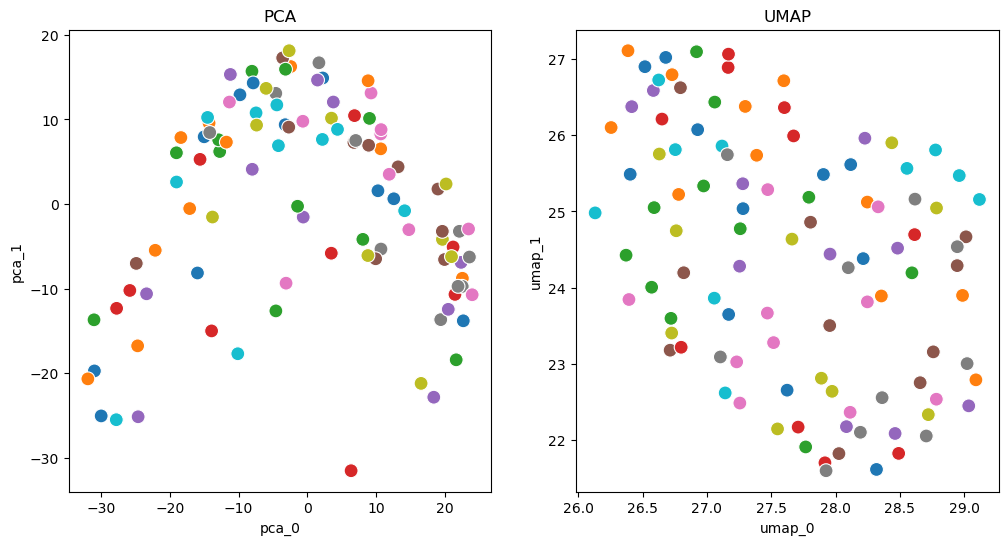

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# plot on PCA and UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_model = PCA(n_components=2)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_df)
pca_result = pca_model.fit_transform(features_scaled)
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(features_scaled)
df["pca_0"] = pca_result[:, 0]
df["pca_1"] = pca_result[:, 1]
df["umap_0"] = umap_result[:, 0]
df["umap_1"] = umap_result[:, 1]
# Plot PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x="pca_0", y="pca_1", hue="well_fov", palette="tab10", s=100)
plt.title("PCA")
# remove legend for clarity
plt.legend([], [], frameon=False)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x="umap_0", y="umap_1", hue="well_fov", palette="tab10", s=100)
plt.title("UMAP")
# remove legend for clarity
plt.legend([], [], frameon=False)
plt.show()

## Run the same images on SAMMED3d

In [12]:
import urllib.request

sam3dmed_checkpoint_url = (
    "https://huggingface.co/blueyo0/SAM-Med3D/resolve/main/sam_med3d_turbo.pth"
)
sam3dmed_checkpoint_path = pathlib.Path("../models/sam-med3d-turbo.pth").resolve()
if not sam3dmed_checkpoint_path.exists():
    sam3dmed_checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    urllib.request.urlretrieve(sam3dmed_checkpoint_url, str(sam3dmed_checkpoint_path))

In [13]:
from sammed3d_featurizer import call_whole_image_sammed3d_pipeline

In [14]:
list_of_feature_dicts = []
for image_index in range(images.shape[0]):
    image = images[image_index].cpu().numpy()
    output_dict = call_whole_image_sammed3d_pipeline(
        image=image,
        SAMMed3D_model_path=str(sam3dmed_checkpoint_path),
        feature_type="cls",
    )
    output_dict["index"] = [image_index] * len(output_dict["feature_name"])
    list_of_feature_dicts.append(output_dict)

✓ Loading SAM-Med3D via MedIM from /home/lippincm/Documents/NF1_3D_organoid_profiling_pipeline/2.segment_images/models/sam-med3d-turbo.pth
creating model SAM-Med3D
try to load pretrained weights from /home/lippincm/Documents/NF1_3D_organoid_profiling_pipeline/2.segment_images/models/sam-med3d-turbo.pth
✓ Successfully loaded pretrained SAM-Med3D-turbo
✓ Loading SAM-Med3D via MedIM from /home/lippincm/Documents/NF1_3D_organoid_profiling_pipeline/2.segment_images/models/sam-med3d-turbo.pth
creating model SAM-Med3D
try to load pretrained weights from /home/lippincm/Documents/NF1_3D_organoid_profiling_pipeline/2.segment_images/models/sam-med3d-turbo.pth
✓ Successfully loaded pretrained SAM-Med3D-turbo
✓ Loading SAM-Med3D via MedIM from /home/lippincm/Documents/NF1_3D_organoid_profiling_pipeline/2.segment_images/models/sam-med3d-turbo.pth
creating model SAM-Med3D
try to load pretrained weights from /home/lippincm/Documents/NF1_3D_organoid_profiling_pipeline/2.segment_images/models/sam-med3d-

In [15]:
for key in output_dict.keys():
    print(len(output_dict[key]))

384
384
384
384


In [16]:
df = pd.concat(
    [pd.DataFrame(feature_dict) for feature_dict in list_of_feature_dicts],
    ignore_index=True,
)
df.head()

,feature_name,value,feature_type,index
0,SAMMed3D_feature_0,-0.459780,cls,0
1,SAMMed3D_feature_1,-0.343509,cls,0
2,SAMMed3D_feature_2,-0.013670,cls,0
3,SAMMed3D_feature_3,0.003209,cls,0
4,SAMMed3D_feature_4,0.039444,cls,0


In [17]:
# melt the dataframe
df = (
    df.pivot(index="index", columns="feature_name", values="value")
    .reset_index()
    .drop(columns=["index"])
)
df.head()

feature_name,SAMMed3D_feature_0,SAMMed3D_feature_1,SAMMed3D_feature_10,SAMMed3D_feature_100,SAMMed3D_feature_101,SAMMed3D_feature_102,SAMMed3D_feature_103,SAMMed3D_feature_104,SAMMed3D_feature_105,SAMMed3D_feature_106,...,SAMMed3D_feature_90,SAMMed3D_feature_91,SAMMed3D_feature_92,SAMMed3D_feature_93,SAMMed3D_feature_94,SAMMed3D_feature_95,SAMMed3D_feature_96,SAMMed3D_feature_97,SAMMed3D_feature_98,SAMMed3D_feature_99
0,-0.459780,-0.343509,0.233232,-0.069701,-0.127442,0.097991,0.006967,-0.080170,-0.253313,-0.037856,...,-0.005699,-0.059760,0.050745,-0.010765,0.036948,0.035717,0.013418,0.246560,0.343688,0.250931
1,-0.211378,-0.311673,0.215696,-0.008545,-0.143982,0.215228,0.006266,-0.125375,-0.206888,-0.078953,...,-0.005324,-0.110837,-0.030766,-0.010990,0.020611,0.046058,0.036881,0.163886,0.414310,0.127823
2,-0.312135,-0.254733,0.249257,0.036186,-0.118128,0.168178,0.030792,-0.090479,-0.233520,-0.062752,...,-0.006096,-0.128268,0.032559,-0.010984,0.022706,0.031313,0.024071,0.169385,0.356968,0.151935
3,-0.262710,-0.246379,0.230781,-0.001538,-0.131013,0.224762,0.059945,-0.113509,-0.182379,-0.045759,...,-0.005473,-0.119063,0.020996,-0.011189,0.017963,-0.000065,0.012259,0.186884,0.368873,0.148072
4,-0.229928,-0.270831,0.216052,-0.009138,-0.118666,0.231144,0.009709,-0.126977,-0.198253,-0.082507,...,-0.005394,-0.123663,-0.004789,-0.011127,0.024638,0.026625,0.027398,0.156897,0.393140,0.133868


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# run PCA and UMAP on SAMMed3D features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_model = PCA(n_components=2)
scaler = StandardScaler()
features = df.copy()
metadata = df.copy()
features_scaled = scaler.fit_transform(features)

In [19]:
pca_result = pca_model.fit_transform(features_scaled)
umap_model = umap.UMAP(n_components=2, random_state=0)
umap_result = umap_model.fit_transform(features_scaled)
df["pca_0"] = pca_result[:, 0]
df["pca_1"] = pca_result[:, 1]
df["umap_0"] = umap_result[:, 0]
df["umap_1"] = umap_result[:, 1]
df.reset_index(inplace=True)
df.head()

/home/lippincm/miniforge3/envs/GFF_segmentation_nuclei/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


feature_name,index,SAMMed3D_feature_0,SAMMed3D_feature_1,SAMMed3D_feature_10,SAMMed3D_feature_100,SAMMed3D_feature_101,SAMMed3D_feature_102,SAMMed3D_feature_103,SAMMed3D_feature_104,SAMMed3D_feature_105,...,SAMMed3D_feature_94,SAMMed3D_feature_95,SAMMed3D_feature_96,SAMMed3D_feature_97,SAMMed3D_feature_98,SAMMed3D_feature_99,pca_0,pca_1,umap_0,umap_1
0,0,-0.459780,-0.343509,0.233232,-0.069701,-0.127442,0.097991,0.006967,-0.080170,-0.253313,...,0.036948,0.035717,0.013418,0.246560,0.343688,0.250931,-9.527298,-16.777456,1.012467,22.706371
1,1,-0.211378,-0.311673,0.215696,-0.008545,-0.143982,0.215228,0.006266,-0.125375,-0.206888,...,0.020611,0.046058,0.036881,0.163886,0.414310,0.127823,18.198833,0.386042,0.594979,17.982752
2,2,-0.312135,-0.254733,0.249257,0.036186,-0.118128,0.168178,0.030792,-0.090479,-0.233520,...,0.022706,0.031313,0.024071,0.169385,0.356968,0.151935,5.274493,0.430664,1.099458,20.202673
3,3,-0.262710,-0.246379,0.230781,-0.001538,-0.131013,0.224762,0.059945,-0.113509,-0.182379,...,0.017963,-0.000065,0.012259,0.186884,0.368873,0.148072,10.762987,1.253015,0.426322,19.629469
4,4,-0.229928,-0.270831,0.216052,-0.009138,-0.118666,0.231144,0.009709,-0.126977,-0.198253,...,0.024638,0.026625,0.027398,0.156897,0.393140,0.133868,17.859190,2.731112,0.429271,18.293121


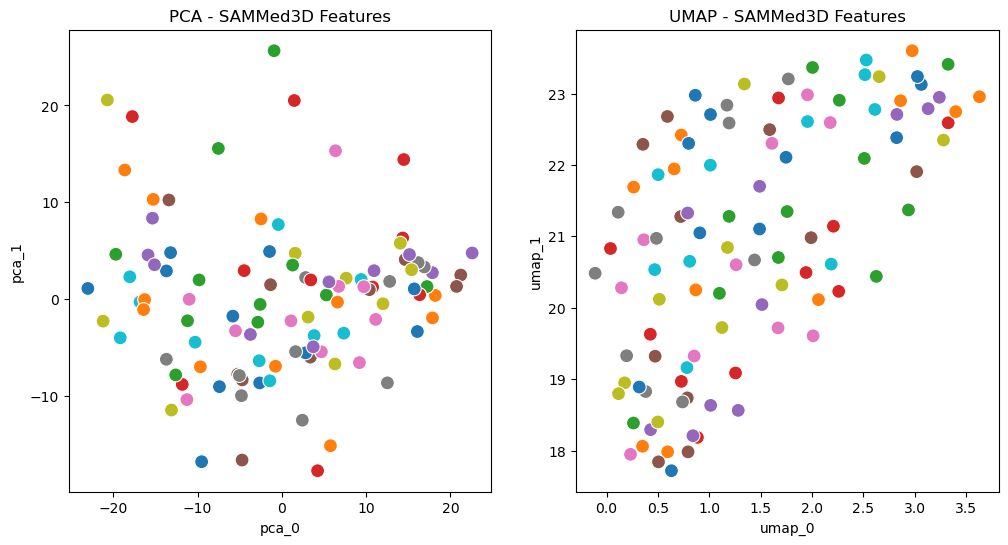

In [20]:
# Plot PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x="pca_0", y="pca_1", hue="index", palette="tab10", s=100)
plt.title("PCA - SAMMed3D Features")
# remove legend for clarity
plt.legend([], [], frameon=False)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x="umap_0", y="umap_1", hue="index", palette="tab10", s=100)
plt.title("UMAP - SAMMed3D Features")
# remove legend for clarity
plt.legend([], [], frameon=False)
plt.show()